In [149]:
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import matplotlib.dates as mdates
import time
pandarallel.initialize()


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [453]:
plt.style.use('MNRAS_stylesheet')

In [195]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        tstart=time.time()
        # Get list of all files
        flist = glob('./MSFT/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        print("Lengths",[len(w) for w in dfs])
        total_length1 = np.sum([len(w) for w in dfs])
        print(np.round(time.time()-tstart,2),"Read data")
        # Select only exchange "Q"
        dfs= Parallel(n_jobs=8)(delayed(self.select_exchange)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Selected on exchange")
        total_length2 = np.sum([len(w) for w in dfs])
        # Drop corrected
        dfs= Parallel(n_jobs=8)(delayed(self.drop_corr)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Dropped corrected")
        total_length3 = np.sum([len(w) for w in dfs])
        #pd.concat(dfs).to_pickle('MSFT_2015_2020_highres.pickle')
        # Aggregate to second level(otherwise things are way too slow)
        dfs= Parallel(n_jobs=8)(delayed(self.to_seconds)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Made seconds from millisecond data")
        total_length4 = np.sum([len(w) for w in dfs])
        # Group by datetime (sum of sizes and median of prices)
        dfs= Parallel(n_jobs=8)(delayed(self.aggregate)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Grouped by datetime")
        total_length5 = np.sum([len(w) for w in dfs])
        # Remove low outliers
        #dfs= Parallel(n_jobs=8)(delayed(self.neg_outlier)(i) for i in dfs)
        #print(np.round(time.time()-tstart,2),"Removed low outliers")
        # Get datetime and drop unknowns
        dfs= Parallel(n_jobs=8)(delayed(self.clean)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Converted to datetimes")
        total_length6 = np.sum([len(w) for w in dfs])

        # Concatenate them vertically
        self.df = pd.concat(dfs)        
        # Sort them
        self.sort()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        print(np.round(time.time()-tstart,2), "Done")
        print(total_length1, total_length2, total_length3, 
              total_length4, total_length5, total_length6)
        
        
    def to_seconds(self,df):
        df['time_sec'] = df.TIME_M.apply(lambda x: x.split('.')[0])
        return df
    
    def select_exchange(self,df):
        return df[df.EX=='Q']
        
    def clean(self,df):
        # Remove 9999.999 values
        df = df.drop(df[df.PRICE>5000].index)
        df = df.reset_index()
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['time_sec']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])
        return df
        
        
    def neg_outlier(self,df):
        # rolling window to remove outliers at 60std
        prices = df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        df = df.drop(outliers)
        return df
        
    def drop_corr(self,df):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        df = df[df.TR_CORR==0]
        return df
        
        
    def aggregate(self,df):
        # Groupby datetime (e.g. two ticks at same moment become one)
        df = pd.DataFrame({'SIZE':df.groupby(['DATE','time_sec']).SIZE.sum(),
                           'PRICE':df.groupby(['DATE','time_sec']).PRICE.median()})
        return df
        
    def sort(self):
        self.df = self.df[['SIZE','PRICE','DATETIME']].set_index('DATETIME')
        self.df = self.df.sort_index()
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('MSFT_2015_2020.pickle')
        self.hourly.to_pickle('MSFT_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()

KeyboardInterrupt: 

In [2]:
# Read in pickle file
df = pd.read_pickle('MSFT_2015_2020.pickle')

In [243]:
# Highres df (either all (Luuk) or COVID period
df_highres = pd.read_pickle('MSFT_2015_2020_highres.pickle')
df_highres_covid = pd.read_pickle('COVID_highres.pickle')

In [ ]:
# Read in splitted files
df = pd.concat([pd.read_pickle(w) for w in ['df.part1.pickle','df.part2.pickle','df.part3.pickle']])

In [ ]:
corona_peak = df.loc['2020-03-16']

In [ ]:
def plot_one_day():
    plt.figure(figsize=(3.321,2))
    plt.scatter(corona_peak.index, corona_peak.PRICE,s=0.02,color='black')
    
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.xlabel('Time')
    plt.yticks(np.arange(135,149,3))
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_intraday.pdf')
    
    plt.show()
def plot_all():
    plt.figure(figsize=(3.321,2))
    plt.plot(df.index, df.PRICE,color='black',lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_6years.pdf')
    plt.show()
plot_one_day()
plot_all()

In [ ]:
from scipy.stats import norm
class realized_variance():
    def __init__(self):
#         self.df = pd.read_pickle('MSFT_2015_2020.pickle')
        self.df = df
        self.df = self.df[['PRICE']].resample("5T").median() 
        self.to_returns()
        self.RV()
        self.RVOL()
        self.plot()
        return
    
    def to_returns(self):
        self.logprice = np.log(self.df[['PRICE']])
        self.returns  = (self.logprice.diff()*100).iloc[1:]
        
    def get_df(self):
        return self.returns
    
    def RV(self):
        values = self.returns#.iloc[:10000]
        values.columns = ['return']
        """values['day'] = pd.Series(values.index).apply(lambda x: pd.to_datetime(x.strftime("%Y-%m-%d"))).values
        kernel_mu  = self.returns.resample("1D").mean()
        kernel_mu.columns = ['mean']
        kernel_std = self.returns.resample("1D").std()
        kernel_std.columns = ['std']
        values = pd.merge(values,kernel_mu, left_on='day',right_index=True)
        values = pd.merge(values,kernel_std, left_on='day',right_index=True)
        
        weights = norm(values['mean'], values['std']).pdf(values['return'])"""
        weighted_return = values['return']**2 #*weights
        self.RV = weighted_return.resample("1D").sum()
        self.RV = self.RV[(self.RV != 0)]
        
    def RVOL(self):
        self.RVOL = np.sqrt(self.RV)
        self.RVOL = self.RVOL*np.sqrt(252)
        
    def plot(self):
        fig,ax = plt.subplots()
        ax.plot(self.RVOL,label='RVOL')
        (self.returns*100).rolling(40).std().plot(color='red',ax=ax,label='Rolling std')
        plt.legend()
        plt.show()

relvar = realized_variance()
retdf=relvar.get_df()

In [ ]:
from scipy.stats import norm
class RV_highfrequency():
    def __init__(self):
        self.df = df.loc['2020-03-19']
        self.df = self.df[['PRICE']]
        self.to_returns()
        self.RV()
        self.RV_parzen()
        self.RVOL()
        self.plot()
        return
    
    def to_returns(self):
        self.logprice = np.log(self.df[['PRICE']])
        self.returns  = (self.logprice.diff()*100).iloc[1:]
        
    def get_df(self):
        return self.returns
    
    def Parzen(self,x):
        if 0<=x<=1/2:
            return 1-6*x**2+6*x**3
        elif 1/2<=x<=1:
            return 2*(1-x)**3
        elif x>1:
            return 0
        
    def Kernel(self):
        values = self.returns
        values.columns = ['return']
        weights = np.zeros(len(values['return']))
        for i, value in enumerate(values['return']):
            weights[i] = self.Parzen(abs(value))
        return weights
    
    def RV(self):
        values = self.returns
        values.columns = ['return']
        weighted_return = values['return']**2 #*weights
        self.RV = weighted_return
        
    def RV_gauss(self):
        values = self.returns
        values.columns = ['return']
        values['day'] = pd.Series(values.index).apply(lambda x: pd.to_datetime(x.strftime("%Y-%m-%d"))).values
        kernel_mu  = self.returns.resample("1D").mean()
        kernel_mu.columns = ['mean']
        kernel_std = self.returns.resample("1D").std()
        kernel_std.columns = ['std']
        values = pd.merge(values,kernel_mu, left_on='day',right_index=True)
        values = pd.merge(values,kernel_std, left_on='day',right_index=True)
        
        weights = norm(values['mean'], values['std']).pdf(values['return'])
        weighted_return = weights*values['return']**2 #*weights
        self.RV_gauss = weighted_return  
    
    def RV_parzen(self):
        weights = self.Kernel()
        values = self.returns
        values.columns = ['return']
        weighted_return = weights*values['return']**2 #*weights
        self.RV_parzen = weighted_return
        
    def RVOL(self):
        self.RVOL = np.sqrt(self.RV)
        self.RVOL = self.RVOL.resample("5S").median()
        self.RVOL = self.RVOL*np.sqrt(252*60*6.5)
        
        self.RVOL_parzen = np.sqrt(self.RV_parzen)
        self.RVOL_parzen = self.RVOL_parzen.resample("5S").median()
        self.RVOL_parzen = self.RVOL_parzen*np.sqrt(252*60*6.5)
        
#         self.RVOL_gauss = np.sqrt(self.RV_gauss)
#         self.RVOL_gauss = self.RVOL_gauss.resample("60S").median()
#         self.RVOL_gauss = self.RVOL_gauss*np.sqrt(252*60*6.5)
        
    def plot(self):
        plt.plot(self.RVOL,label='RVOL', color='black', ls='--')
        plt.plot(self.RVOL_parzen, label='RVOL Parzen', alpha=0.5)
        plt.legend()
        plt.show()
        
        
relvar = RV_highfrequency()
retdf=relvar.get_df()


In [410]:
closingprices = df[['PRICE']].groupby(df.index.date).apply(lambda x: x.iloc[[-1]])
closingprices.index = closingprices.index.droplevel(0)
daily_returns = np.log(closingprices).diff().iloc[1:]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8314323982774017
            Iterations: 28
            Function evaluations: 253
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7941882413951815
            Iterations: 35
            Function evaluations: 320
            Gradient evaluations: 35


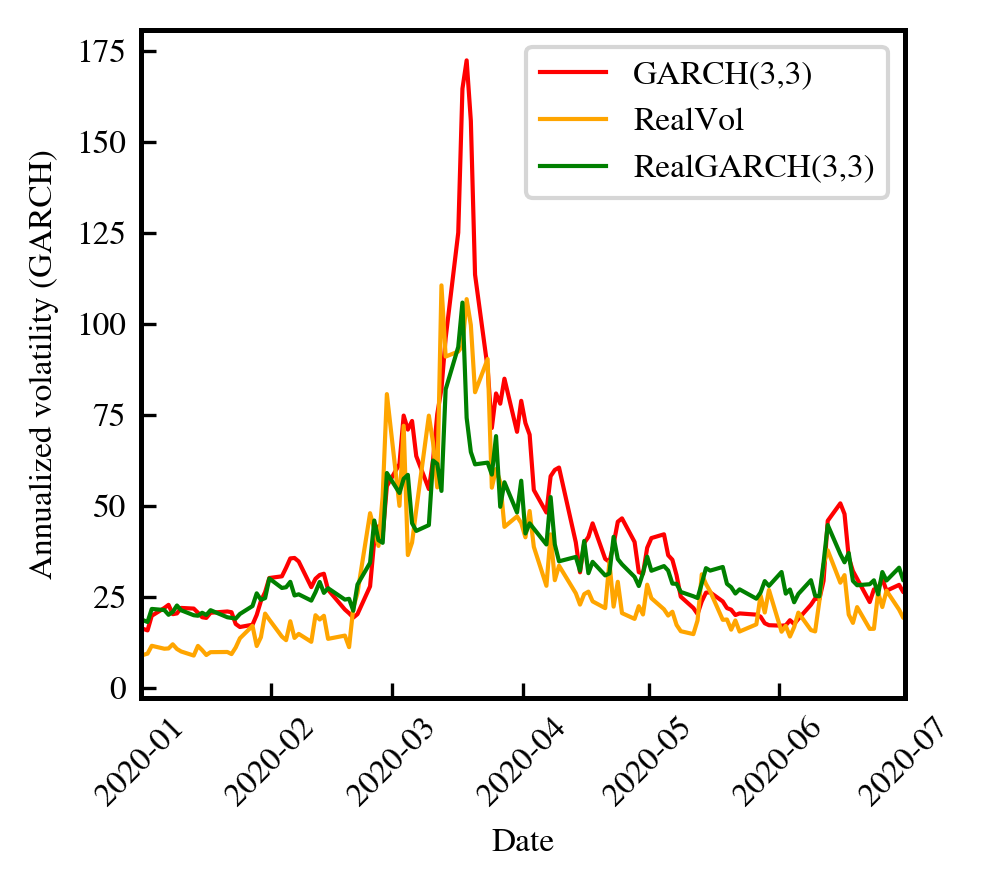

In [541]:
# REALGARCH 1:
# Here I have in the updating equation beta*(lagged RVOL) + alpha*(lagged return)
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':200}
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum()*252)
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def __llik_fun_GARCH__(self,params):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta = betas[i]
                # In the case of normal GARCH:
                if self.model=='GARCH':
                    beta_part = beta_part+beta*sigma2[t-i-1]
                # In the case of RealGARCH model
                if self.model == 'RealGARCH':
                    beta_part = beta_part+beta*self.RVOL[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            # Combine in sigma2[t]
            sigma2[t] = omega + alpha_part + beta_part
        # Derive likelihood
        L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
        llik = np.mean(L)
        return -1*llik
    
    def fit_garch(self,x):
        # Initialize values
        self.p,self.q = 3,3
        b = np.ones(self.p)*0.2  # initial value for beta
        a = np.ones(self.q)*0.1 # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        
        par_ini = np.hstack((par_ini,alphas, betas))
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        estimates = est.x
        omega_hat = np.exp(estimates[0])
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1+self.p:]])
        
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        
        
    def plot_vola(self):
        x = self.closingreturns
        n = len(x)

        sigma2 = np.zeros(n)
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        
        for t in range(max(self.p,self.q)+1,n):
            alpha_part = 0
            beta_part  = 0
            for i in range(0,self.p):
                beta = self.thetahat[1+self.q:][i]
                # In the case of normal GARCH:
                if self.model=='GARCH':
                    beta_part = beta_part+beta*sigma2[t-i-1]
                # In the case of RealGARCH model
                if self.model == 'RealGARCH':
                    beta_part = beta_part+beta*self.RVOL[t-i-1]
            
            for i in range(0,self.q):
                alpha = self.thetahat[1:self.q+1][i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            
            sigma2[t] = self.thetahat[0] + alpha_part + beta_part
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)

GARCH = estimate_GARCH(model='GARCH')
GARCH_time, GARCH_vola = GARCH.plot_vola()
GARCH = estimate_GARCH(model='RealGARCH')
RealGARCH_time, RealGARCH_vola = GARCH.plot_vola()

def plot_GARCHestimates():
    import datetime
    plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=1,color='red')
    plt.plot(RealGARCH_time,GARCH.RVOL,lw=1,label='RealVol',color='orange')
    plt.plot(RealGARCH_time, RealGARCH_vola,label='RealGARCH(3,3)',lw=1,color='green')
    plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020, 7, 1)])
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Annualized volatility (GARCH)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()

In [542]:
#Realgarch2
# Here I have updating equation sigma2 = beta*(lagged sigma2) + gamma*(lagged RVOL) + alpha*(lagged returns)
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':200}
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum()*252)
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def __llik_fun_GARCH__(self,params):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        gammas = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        if self.model == 'RealGARCH':
            for i in range(0,self.q):
                gammas[i] = np.exp(params[i+self.q+self.p+1])/(1+np.exp(params[i+self.q+self.p+1]))
        
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            gamma_part = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta  = betas[i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain gamma part (lagged RealVol)
            if self.model == 'RealGARCH':
                for i in range(0,self.q):
                    gamma = gammas[i]
                    gamma_part = gamma_part+gamma*self.RVOL[t-i-1]**2
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            # Combine in sigma2[t]
            if self.model=='GARCH':
                sigma2[t] = omega + alpha_part + beta_part
            elif self.model=='RealGARCH':
                sigma2[t] = omega + alpha_part + beta_part + gamma_part
        # Derive likelihood
        L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
        llik = np.mean(L)
        
        return -1*llik
    
    def fit_garch(self,x):
        # Initialize values
        self.p,self.q = 1,1
        b = np.ones(self.p)*0.2  # initial value for beta
        a = np.ones(self.q)*0.1 # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        if self.model=='RealGARCH':
            # Define gammas for the lagged dependence on x
            g = np.ones(self.q)*0.1
            gammas = np.zeros(self.p)
            
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        if self.model == 'RealGARCH':
            for i in range(0,self.p):
                gammas[i] = np.log(g[i]/(1-g[i]))
        if self.model == 'GARCH':
            par_ini = np.hstack((par_ini,alphas, betas))
        if self.model =='RealGARCH':
            par_ini = np.hstack((par_ini,alphas, betas,gammas))
        
        
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        estimates = est.x
        omega_hat = np.exp(estimates[0])
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1+self.p:self.p+self.q+1]])
        
        if self.model == 'RealGARCH':
            gammas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1+self.p+self.q:]])
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        if self.model=='RealGARCH':
            self.thetahat = np.hstack((self.thetahat,gammas))
        
        
    def plot_vola(self):
        x = self.closingreturns
        n = len(x)

        sigma2 = np.zeros(n)
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        
        
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            gamma_part = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta  = self.thetahat[1+self.q:1+self.q+self.p][i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain gamma part (lagged RealVol)
            if self.model == 'RealGARCH':
                for i in range(0,self.q):
                    gamma = self.thetahat[1+self.p+self.q:][i]
                    gamma_part = gamma_part+gamma*self.RVOL[t-i-1]**2
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = self.thetahat[1:self.q+1][i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            # Combine in sigma2[t]
            if self.model=='GARCH':
                sigma2[t] = omega + alpha_part + beta_part
            elif self.model=='RealGARCH':
                sigma2[t] = self.thetahat[0] + alpha_part + beta_part + gamma_part

                
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)

GARCH = estimate_GARCH(model='GARCH')
GARCH_time, GARCH_vola = GARCH.plot_vola()
GARCH = estimate_GARCH(model='RealGARCH')
RealGARCH_time, RealGARCH_vola = GARCH.plot_vola()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8320571995871417
            Iterations: 23
            Function evaluations: 115
            Gradient evaluations: 23


NameError: name 'omega' is not defined

In [ ]:
def plot_GARCHestimates():
    import datetime
    plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=1,color='red')
    plt.plot(RealGARCH_time,GARCH.RVOL,lw=1,label='RealVol',color='orange')
    plt.plot(RealGARCH_time, RealGARCH_vola,label='RealGARCH(3,3)',lw=1,color='green')
    plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020, 7, 1)])
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Annualized volatility (GARCH)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()

array([16.80974 , 20.41883 , 18.394552, ..., 15.813448, 16.613632,
       15.437398], dtype=float32)

In [ ]:
results = []
for start in np.linspace(0,1e5,int(1e3),dtype=int):
    H=0
    h = np.arange(0,H,1,dtype=int)
    a=retdf.iloc[start:start+int(1e5)].values.flatten()
    def gamma_h(h):
        return np.sum((a*np.roll(a,h))[h:])
    gammas = np.array([gamma_h(w) for w in h])
    ks     = np.array([Parzen(w/(H+1)) for w in h])
    K = np.sum(ks*gammas)
    results.append(K)

In [ ]:
#######################################
###                                 ###
###    STEP 2: Daily volatility     ###
###                                 ###
#######################################
def Parzen(x):
    if 0<=x<=1/2:
        return 1-6*x**2+6*x**3
    elif 1/2<=x<=1:
        return 2*(1-x)**3
    elif x>1:
        return 0
plt.figure()
plt.plot(np.arange(-1,1,0.01),[Parzen(w) for w in np.arange(-1,1,0.01)])
plt.xlabel('x')
plt.ylabel('Parzen k(x)')
plt.show()

In [ ]:
class volatility():
    def __init__(self):
        self.timeseries = df[['PRICE']]
        return
    
    
    def Parzen(self,x):
        if 0<=x<=1/2:
            return 1-6*x**2+6*x**3
        elif 1/2<=x<=1:
            return 2*(1-x)**3
        elif x>1:
            return 0
        
    def sparse_variance(self):
        self.timeseries

In [ ]:
df

In [ ]:
df.iloc[5:1205].PRICE.var()

In [ ]:
spx = df[['PRICE']].iloc[:1000000]

In [ ]:
spx['sqrt']= np.sqrt(spx['PRICE'])
spx['log_sqrt'] = np.log(spx['sqrt'])

In [ ]:
def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    



In [ ]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [125]:
df_highres['LOGPRICE'] = np.log(df_highres.PRICE)
df_highres['DELTALOG'] = df_highres.LOGPRICE.diff()*100
newday = pd.Series(df_highres.index).diff()[pd.Series(df_highres.index).diff()>pd.Timedelta('1h')].index
df_highres.loc[df_highres.iloc[newday].index,'DELTALOG']=np.nan

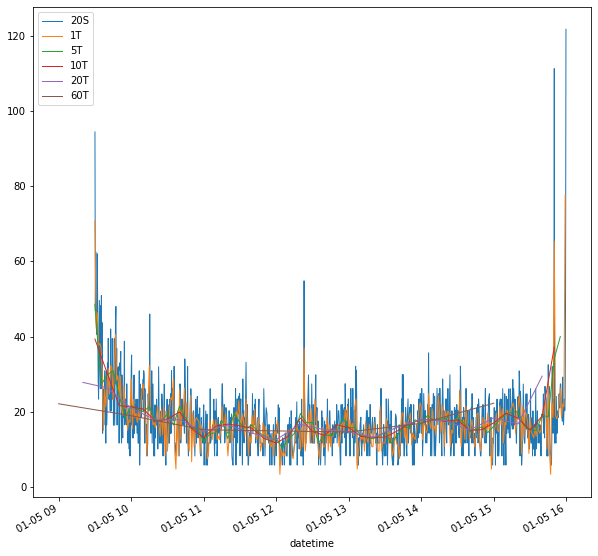

In [60]:
Ns = [6.5*3600/20, 6.5*3600/60, 6.5*3600/300, 6.5*3600/600, 6.5*3600/1200, 6.5]
plt.figure(figsize=(10,10))
for i,timesampling in enumerate(['20S','1T','5T','10T','20T', '60T']):
    RV = (df_highres.DELTALOG**2).resample(timesampling).sum()
    RV = RV[(df_highres.DELTALOG**2).resample(timesampling).count()>0]
    RVOL = RV**(1/2)
    RVOL *= np.sqrt(252)
    RVOL *= np.sqrt(Ns[i])
    RVOL = RVOL[RVOL>0]
    RVOL.loc['2015-01-05'].plot(label=timesampling,lw=1)
plt.legend()
plt.savefig('RVOL.pdf')


In [126]:
df_highres = df_highres.iloc[:20000000]

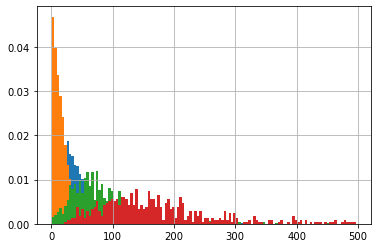

In [49]:
df_highres.resample('30S').count().PRICE.hist(bins=np.arange(1,500,4),density=True)
df_highres.resample('10S').count().PRICE.hist(bins=np.arange(1,500,4),density=True)
df_highres.resample('1T').count().PRICE.hist(bins=np.arange(1,500,4),density=True)
df_highres.resample('2T').count().PRICE.hist(bins=np.arange(1,500,4),density=True)

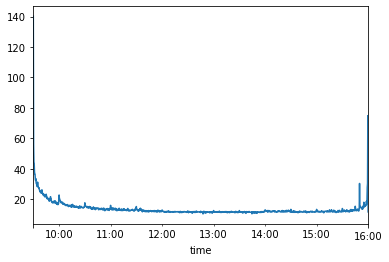

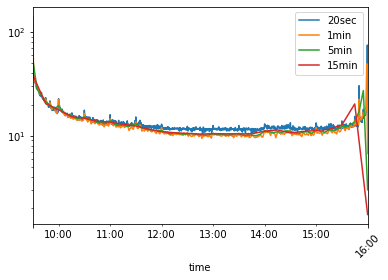

In [234]:
a=pd.DataFrame((df_highres.DELTALOG**2).resample('20S').sum()).reset_index()
a['time']=a.datetime.apply(lambda x: x.strftime('%H:%M:%S'))
a=a[a.DELTALOG>0]
a=a.groupby('time').DELTALOG.median()
a = np.sqrt(a*252*6.5*3600/20)
a.index = pd.to_datetime(a.index)
a.plot(label='20sec')


a=pd.DataFrame((df_highres.DELTALOG**2).resample('1T').sum()).reset_index()
a['time']=a.datetime.apply(lambda x: x.strftime('%H:%M:%S'))
a=a[a.DELTALOG>0]
a=a.groupby('time').DELTALOG.median()
a = np.sqrt(a*252*6.5*60)
a.index = pd.to_datetime(a.index)
a.plot(label='1min')

a=pd.DataFrame((df_highres.DELTALOG**2).resample('5T').sum()).reset_index()
a['time']=a.datetime.apply(lambda x: x.strftime('%H:%M:%S'))
a=a[a.DELTALOG>0]
a=a.groupby('time').DELTALOG.median()
a = np.sqrt(a*252*6.5*12)
a.index = pd.to_datetime(a.index)
a.plot(label='5min')

a=pd.DataFrame((df_highres.DELTALOG**2).resample('15T').sum()).reset_index()
a['time']=a.datetime.apply(lambda x: x.strftime('%H:%M:%S'))
a=a[a.DELTALOG>0]
a=a.groupby('time').DELTALOG.median()
a = np.sqrt(a*252*6.5*4)
a.index = pd.to_datetime(a.index)
a.plot(label='15min')

plt.legend()
plt.semilogy()
plt.xticks(rotation=45)
plt.savefig('./RVOL.pdf')

[]

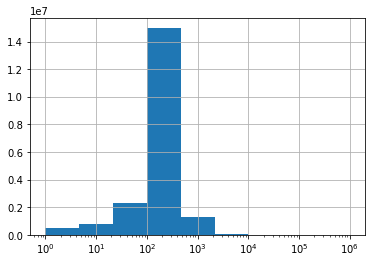

In [132]:
a=pd.DataFrame((df_highres.DELTALOG**2).resample('5T').sum()).reset_index()
a['time']=a.datetime.apply(lambda x: x.strftime('%H:%M:%S'))
a=a[a.DELTALOG>0]
a=a.groupby('time').DELTALOG.median()
a = np.sqrt(a*252*6.5*12)
a.index = pd.to_datetime(a.index)
a.plot(label='5min')


In [230]:
b=df_highres

In [231]:
b= pd.DataFrame(b.SIZE.resample('5T').sum())
b['time']=pd.Series(b.index).apply(lambda x: str(x).split('.')[0]).values
b['time'] = b.time.parallel_apply(lambda x: pd.to_datetime(x).strftime('%H:%M:%S')).values

In [232]:
b = b.groupby('time').SIZE.median()
b = b[b>0]

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 <a list of 11 Text major ticklabel objects>)

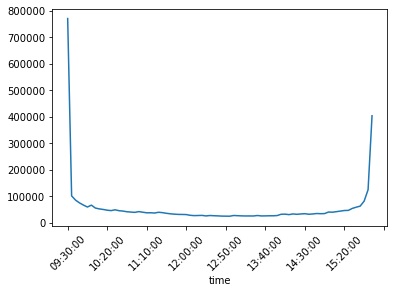

In [233]:
b.plot()
plt.xticks(rotation=45)


In [244]:
df_highres.resample('1D').count().sort_values(by='PRICE')

,PRICE,SIZE
datetime,,
2017-12-23,0,0
2016-07-02,0,0
2016-07-03,0,0
2016-07-04,0,0
2018-10-20,0,0
...,...,...
2020-09-04,248044,248044
2020-03-13,251806,251806
2020-03-17,252610,252610


In [291]:
corona_highres = df_highres.iloc[55000000:60000000].loc['2020-02-28']

In [292]:
corona_highres['LOGPRICE'] = np.log(corona_highres['PRICE'])
corona_highres['DELTALOG'] = corona_highres['LOGPRICE'].diff()
corona_highres['DELTALOG2'] = corona_highres['LOGPRICE'].diff()**2

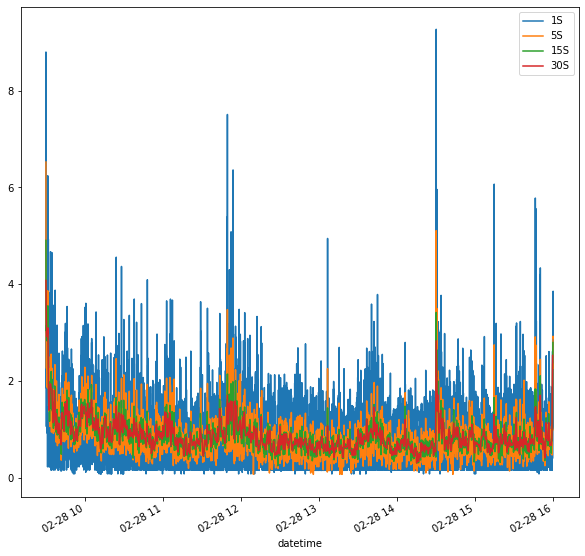

In [293]:
togo=[1,5,15,30]
Ns = [6.5*3600/w for w in togo]
plt.figure(figsize=(10,10))
for i,timesampling in enumerate([str(w)+'S' for w in togo]):
    RV = corona_highres.resample(timesampling).DELTALOG2.sum()
    RVOL = RV**(1/2)
    RVOL *= np.sqrt(252)
    RVOL *= np.sqrt(Ns[i])
    RVOL = RVOL[RVOL>0]
    RVOL.plot(label=timesampling,lw=1.5)
plt.legend()
plt.savefig('RVOL.pdf')




In [539]:
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':200}
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum()*252)
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def __llik_fun_GARCH__(self,params):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        gammas = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        if self.model == 'RealGARCH':
            for i in range(0,self.q):
                gammas[i] = np.exp(params[i+self.q+self.p+1])/(1+np.exp(params[i+self.q+self.p+1]))
        
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            gamma_part = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta  = betas[i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain gamma part (lagged RealVol)
            if self.model == 'RealGARCH':
                for i in range(0,self.q):
                    gamma = gammas[i]
                    gamma_part = gamma_part+gamma*self.RVOL[t-i-1]**2
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            # Combine in sigma2[t]
            if self.model=='GARCH':
                sigma2[t] = omega + alpha_part + beta_part
            elif self.model=='RealGARCH':
                sigma2[t] = omega + alpha_part + beta_part + gamma_part
        # Derive likelihood
        L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
        llik = np.mean(L)
        
        return -1*llik
    
    def fit_garch(self,x):
        # Initialize values
        self.p,self.q = 1,1
        b = np.ones(self.p)*0.2  # initial value for beta
        a = np.ones(self.q)*0.1 # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        if self.model=='RealGARCH':
            # Define gammas for the lagged dependence on x
            g = np.ones(self.q)*0.1
            gammas = np.zeros(self.p)
            
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        if self.model == 'RealGARCH':
            for i in range(0,self.p):
                gammas[i] = np.log(g[i]/(1-g[i]))
        if self.model == 'GARCH':
            par_ini = np.hstack((par_ini,alphas, betas))
        if self.model =='RealGARCH':
            par_ini = np.hstack((par_ini,alphas, betas,gammas))
        
        
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        estimates = est.x
        omega_hat = np.exp(estimates[0])
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1+self.p:self.p+self.q+1]])
        
        if self.model == 'RealGARCH':
            gammas = np.array([np.exp(w)/(1+np.exp(w)) for w in estimates[1+self.p+self.q:]])
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        if self.model=='RealGARCH':
            self.thetahat = np.hstack((self.thetahat,gammas))
        
        
    def plot_vola(self):
        x = self.closingreturns
        n = len(x)

        sigma2 = np.zeros(n)
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        
        
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            gamma_part = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta  = self.thetahat[1+self.q:1+self.q+self.p][i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain gamma part (lagged RealVol)
            if self.model == 'RealGARCH':
                for i in range(0,self.q):
                    gamma = self.thetahat[1+self.p+self.q:][i]
                    gamma_part = gamma_part+gamma*self.RVOL[t-i-1]**2
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = self.thetahat[1:self.q+1][i]
                alpha_part = alpha_part+alpha*x[t-i-1]**2
            # Combine in sigma2[t]
            if self.model=='GARCH':
                sigma2[t] = omega + alpha_part + beta_part
            elif self.model=='RealGARCH':
                sigma2[t] = self.thetahat[0] + alpha_part + beta_part + gamma_part

                
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)

#GARCH = estimate_GARCH(model='GARCH')
#GARCH_time, GARCH_vola = GARCH.plot_vola()
GARCH = estimate_GARCH(model='RealGARCH')
RealGARCH_time, RealGARCH_vola = GARCH.plot_vola()

params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.16945536 -2.19722458 -1.38629436 -2.19722458]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 2.02993186 -2.19936553 -1.48549945 -2.49842409]
params [ 1.27436312 -2.21277397 -1.94034755 -3.97416831]
params [ 1.27436312 -2.21277397 -1.94034755 -3.97416831]
params [ 1.27436312 -2.21277397 -1.94034755 -3.97416831]
params [ 1.27436312 -2.21277397 -1.94034755 -3.97416831]
params [ 1.27436312 -2.21277397 -1.94034755 -3.97416831]
params [ 1.27436312 -2.21277397

params [-24.76079716  -5.84456894  -7.01427567  -4.78540516]
params [-24.76079716  -5.84456894  -7.01427567  -4.78540516]
params [-24.76079716  -5.84456894  -7.01427567  -4.78540516]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-28.85753652  -6.47708993  -7.79417735  -4.78601695]
params [-32.93260622  -7.10606929  -8.56978042  -4.78575121]
params [-32.93260622  -7.10606929  -8.56978042  -4.78575121]
params [-32.93260622  -7.10606929  -8.56978042  -4.78575121]
params [-32.93260622  -7.10606929  -8.56978042  -4.78575121]
params [-32.93260622  -7.10606929  -8.56978042  -4.78575121]
params [-32.93260622  -7.10606929  -8.56978042  -4.7857512 ]
params [-37.36912894  -7.79089341  -9.41422548  -4.78570335]
params [-37.36912894  -7

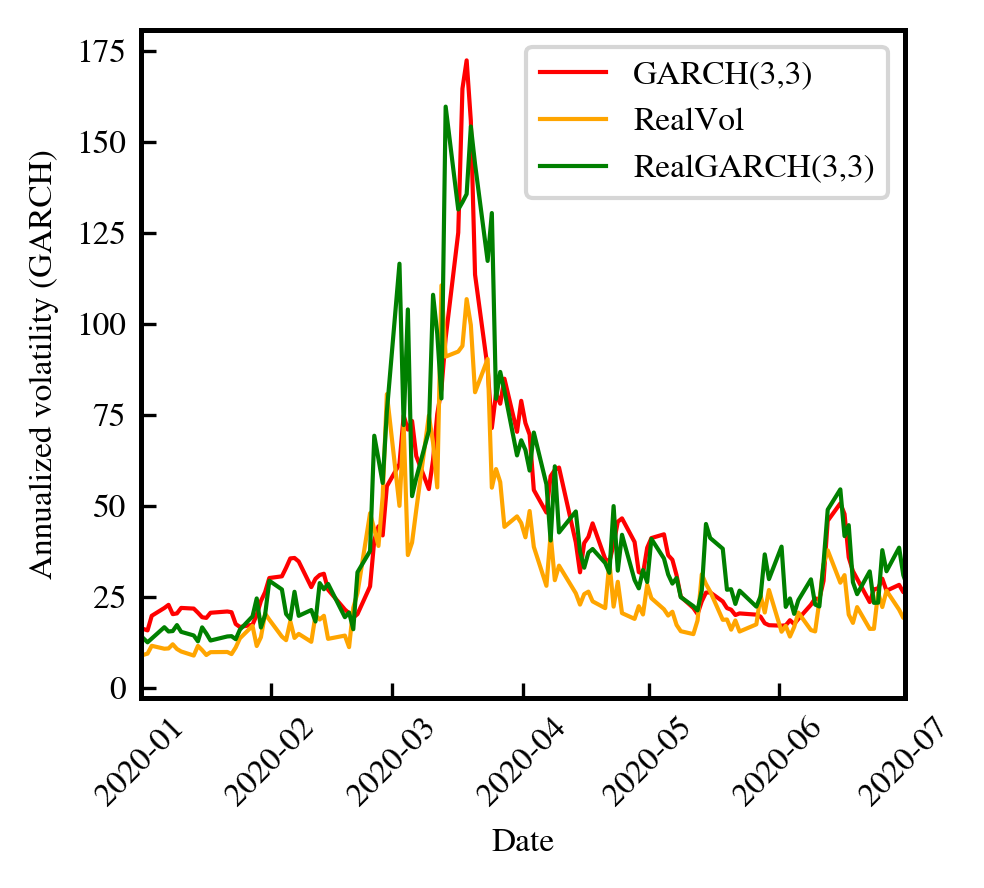

In [540]:
def plot_GARCHestimates():
    import datetime
    plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=1,color='red')
    plt.plot(RealGARCH_time,GARCH.RVOL,lw=1,label='RealVol',color='orange')
    plt.plot(RealGARCH_time, RealGARCH_vola,label='RealGARCH(3,3)',lw=1,color='green')
    plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020, 7, 1)])
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Annualized volatility (GARCH)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()